#### Testing out Gibbs zig-zag code:

In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot

In [2]:
include("zz_structures.jl")
include("mbsampler.jl")

get_clustering (generic function with 1 method)

In [15]:
d, Nobs = 50, 100
p = 1e-1
X = sprandn(d, Nobs, 1e-1)
X[1,:] = ones(Nobs)
ξ_true = rand(Normal(),d).* rand(Binomial(1,0.5), d)
ξ_true[1] = rand(Normal())
y = [rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j]))), 1)[1] + 0. for j in 1:Nobs];
mb_size = 10
σ02 = 1

# prior = HS_prior(d, σ02)
# prior = GDP_prior(d, σ02)
prior = gaussian_prior_nh(zeros(d), 10*rand(d))

gaussian_prior_nh([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [3.50297, 3.91409, 0.470345, 4.99792, 3.04989, 2.27558, 8.55746, 9.84432, 1.6907, 2.29389  …  4.74252, 9.15769, 1.37417, 3.71235, 3.2972, 2.81467, 3.9632, 4.02435, 8.57889, 3.44471])

In [16]:
my_ll = ll_logistic_sp(X,y);
my_model = model(my_ll, prior)
root = find_root(my_model, rand(d));

In [54]:
# Stratified sub-sampling with CV and with weights

norm_Xj = [norm(X[:,j]) for j in 1:Nobs]
weights_cv = spzeros(d, Nobs)
for i in 1:d 
    nz_ind = X[i,:].nzind
    weights_cv[i,nz_ind] = abs.(X[i,nz_ind]).*norm_Xj[nz_ind] 
    weights_cv[i,nz_ind] /= sum(weights_cv[i,nz_ind])
end

ll_pd_root_list = [partial_derivative_vec(my_model.ll, root, i, 1:Nobs) for i in 1:d]

cmbsamplers = Array{mbsampler}(d)
cmbsamplers[1] = umbsampler(Nobs, mb_size)
N_cluster = mb_size
#mode = "wc"

for dim in 2:d
    N_cluster_d = min(N_cluster, length(ll_pd_root_list[dim].nzval))
    
    csamplers = Array{mbsampler}(N_cluster_d)
    #clusters = get_clustering_vec(ll_pd_root_list[dim], N_cluster_d, mode)
    clusters = get_clustering(N_cluster_d, ll_pd_root_list[dim].nzval)
    #clusters = get_clustering_vec(ll_pd_root_list[dim].nzval, N_cluster_d, mode)
    for i in 1:N_cluster_d
        clusters[i] =  ll_pd_root_list[dim].nzind[clusters[i]]
    end

    scp = ones(N_cluster_d)
    for (ci, c) in enumerate(clusters)
        
        csamplers[ci] = wumbsampler(size(c)[1], scp[ci], weights_cv[dim,c])
    end
    #cmbsamplers[dim] = cmbsampler(csamplers, clusters, ones(Nobs)/Nobs)
    cmbsamplers[dim] = spcmbsampler(csamplers, clusters, weights_cv[dim,:])
end
gs_list = cvmbsampler_list(my_model, cmbsamplers, root, true);

In [55]:
A = eye(d)
adapt_speed = true
opf = projopf(A, 100, adapt_speed, hyperparam_size(prior))
opt = maxa_opt(10^6)
outp = outputscheduler(opf,opt);

In [56]:
bb = linear_bound(my_model.ll, my_model.pr, gs_list, zz_state(opf))
update_bound(bb, my_ll, prior, gs_list, zz_state(opf));

In [57]:
print("Initial speed = ", opf.alpha_skeleton[:,opf.tcounter+1])

Initial speed = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [58]:
my_zz_sampler = zz_sampler(0, gs_list, bb)
hyper_sampler = block_gibbs_sampler(1.)
blocksampler = Array{msampler}(2)
blocksampler[1] = my_zz_sampler
blocksampler[2] = hyper_sampler;

In [59]:
start = time()
ZZ_block_sample(my_model::model, outp::outputscheduler, blocksampler::Array{msampler})
print( round((time()-start)/60, 2), " mins")

1.99 mins

In [60]:
size(outp.opf.alpha_skeleton), size(outp.opf.xi_skeleton)

((50, 14850), (50, 14850))

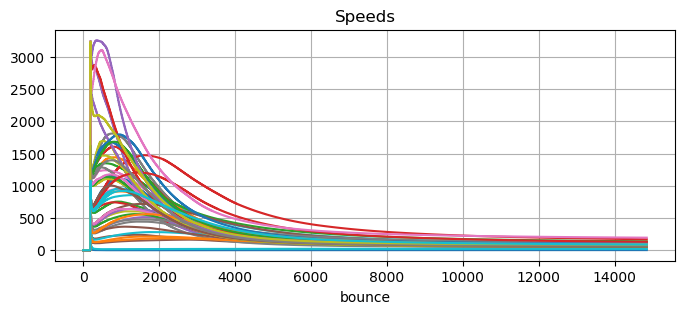

In [61]:
fig = figure("pyplot_barplot",figsize=(8,3))
for i in 1:d 
    plot((outp.opf.alpha_skeleton[i,:]))
end
title("Speeds")
xlabel("bounce")
grid(true)

In [64]:
discard = 6000
n_samples = 10^4
xi_samples = extract_samples(outp.opf.xi_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[:,discard+1:end], 
                             outp.opf.bt_skeleton[end]/n_samples,
                             "linear");
hyper_samples = extract_samples(outp.opf.hyper_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[:,discard+1:end], 
                                outp.opf.bt_skeleton[end]/n_samples, 
                                "constant");

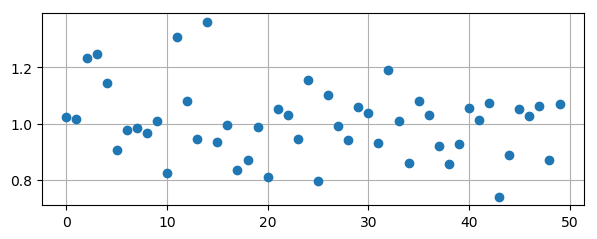

In [65]:
fig = figure("pyplot_barplot",figsize=(7,2.5))
plot([compute_configT(my_model, xi_samples[:,1:end-1], hyper_samples[:,1:end-1], k) for k in 1:d], "o")
grid(true)